## Manufacturing Quality Control Dataset

## Scenario
Kshema Precision Components (KPC) is a mid-size manufacturer producing CNC-milled aluminum housings for the automotive industry. The company wants to improve quality control by predicting potential defects using real-time machine telemetry.

## Problem Statement
The goal is to develop a binary classification model that predicts whether a manufactured unit will be defective based on short-window variability in temperature and pressure readings from the production line. Early detection will help reduce scrap rates and prevent large-scale defective batches.

## Data Description
- **temperature_variance** *(float)*: Standardized measure of variance in coolant and ambient temperature over a short time window. Higher values indicate greater instability.
- **pressure_variance** *(float)*: Standardized measure of variance in hydraulic or pneumatic line pressure over a short time window. Higher values indicate greater instability.
- **defect_found** *(int: 0 or 1)*: Binary target variable where `1` indicates the unit failed end-of-line inspection and was deemed defective.

**Note:** All feature values are in masked and scaled format to maintain confidentiality of proprietary process parameters.

## 1) Imports, seeds

In [6]:
# %pip install tensorflow

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
np.random.seed(42)
tf.random.set_seed(42)

## 2) Binary Logistic Regression (Keras high-level)

In [7]:
# Create a binary classification toy dataset (2D for easy visualization)
df = pd.read_csv("defect_data.csv")
X = df.iloc[:,:-1]
y =df['defect_found']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Logistic regression = linear layer + sigmoid
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_tr.shape[1],)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
!pip install livelossplot

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
   ---------------------------------------  7.1/7.2 MB 43.4 MB/s eta 0:00:01
   ---------------------------------------- 7.2/7.2 MB 31.7 MB/s eta 0:00:00
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)


In [10]:
from livelossplot import PlotLossesKerasTF

In [18]:
X_tr.shape

(3200, 2)

In [19]:
3200/64

50.0

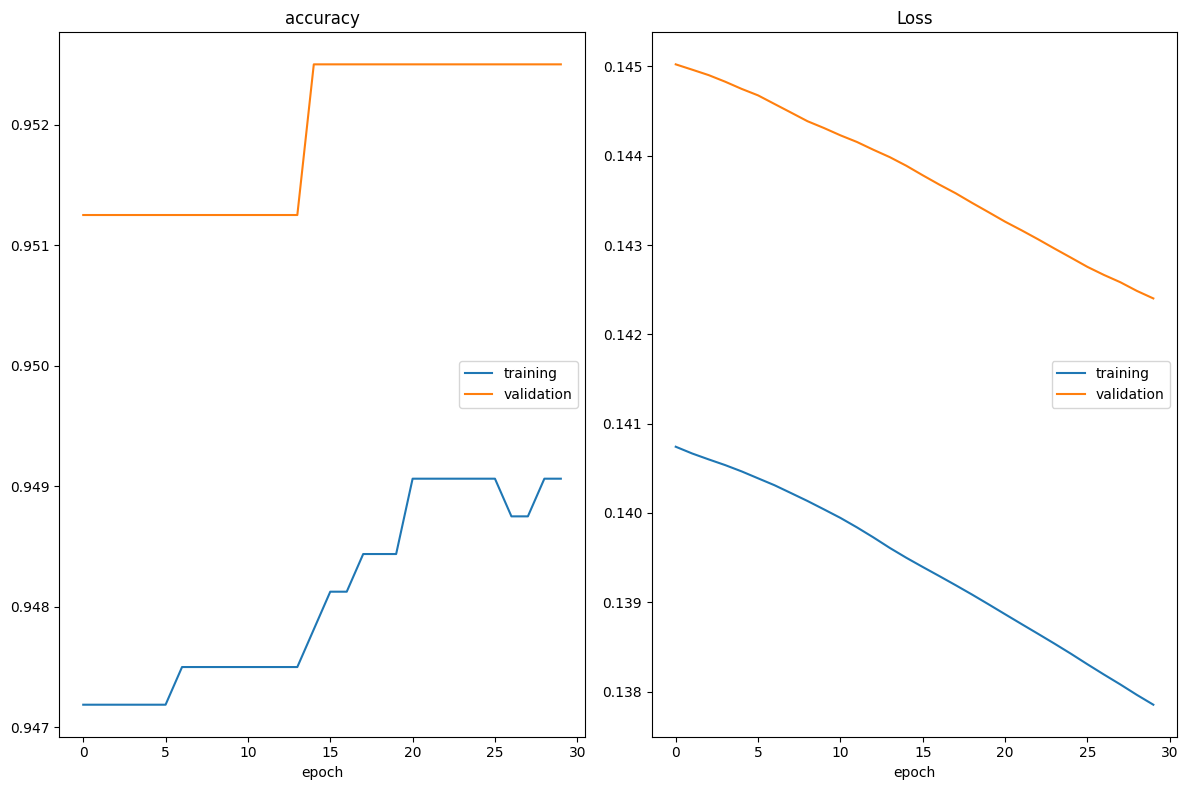

accuracy
	training         	 (min:    0.947, max:    0.949, cur:    0.949)
	validation       	 (min:    0.951, max:    0.952, cur:    0.952)
Loss
	training         	 (min:    0.138, max:    0.141, cur:    0.138)
	validation       	 (min:    0.142, max:    0.145, cur:    0.142)
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9491 - loss: 0.1379 - val_accuracy: 0.9525 - val_loss: 0.1424


In [22]:
history = model.fit(
    X_tr, y_tr,
    epochs=30,
    batch_size=64,
    validation_data=(X_te,y_te),
    callbacks=[PlotLossesKerasTF()]
)

In [ ]:
loss, acc = model.evaluate(X_te, y_te, verbose=0)
print(f"[High-level LR] Test Accuracy: {acc:.3f}")

[High-level LR] Test Accuracy: 0.951


## 3) Decision boundary plot for the binary model

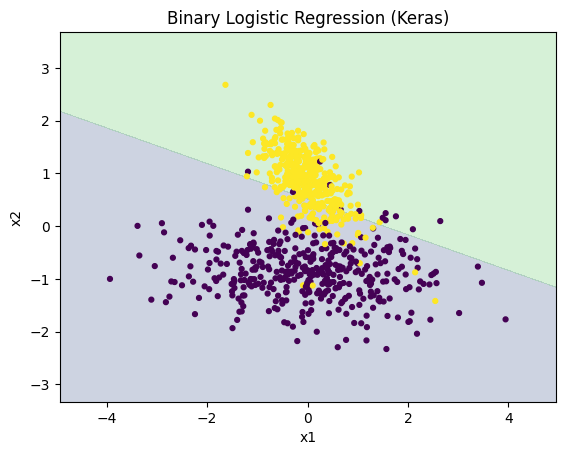

In [5]:
def plot_decision_boundary(clf, X, y, scaler=None, title="Decision Boundary"):
    X_plot = X.copy()
    if scaler is not None:
        # Work in scaled space if the model expects scaled inputs
        X_plot = scaler.transform(X_plot)

    x0_min, x0_max = X[:,0].min()-1, X[:,0].max()+1
    x1_min, x1_max = X[:,1].min()-1, X[:,1].max()+1
    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, 300),
        np.linspace(x1_min, x1_max, 300)
    )
    grid = np.c_[xx0.ravel(), xx1.ravel()]
    grid_in = scaler.transform(grid) if scaler is not None else grid
    preds = clf.predict(grid_in, verbose=0).reshape(xx0.shape)

    plt.figure()
    plt.contourf(xx0, xx1, preds, alpha=0.25, levels=[0,0.5,1])
    plt.scatter(X[:,0], X[:,1], c=y, s=12)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_decision_boundary(model, X_te, y_te, scaler=sc, title="Binary Logistic Regression (Keras)")

## 4) Binary Logistic Regression — Custom Training Loop with GradientTape

In [8]:
# Re-initialize a fresh model for custom loop
custom_lr = tf.keras.Sequential([
    tf.keras.layers.Input((2,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.1)
bce = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(xb, yb):
    # xb: (batch, 2), yb: (batch,)
    yb = tf.reshape(yb, (-1, 1))  # match output shape
    with tf.GradientTape() as tape:
        preds = custom_lr(xb, training=True)
        loss = bce(yb, preds)
    grads = tape.gradient(loss, custom_lr.trainable_variables)
    # (optional) gradient clipping to stabilize
    grads = [tf.clip_by_value(g, -5.0, 5.0) for g in grads]
    opt.apply_gradients(zip(grads, custom_lr.trainable_variables))
    return loss

@tf.function
def eval_step(xb, yb):
    yb = tf.reshape(yb, (-1, 1))
    preds = custom_lr(xb, training=False)
    loss = bce(yb, preds)
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.round(preds), yb), tf.float32))
    return loss, acc

# Prepare numpy → tensors
Xtr_t = tf.convert_to_tensor(X_tr, dtype=tf.float32)
ytr_t = tf.convert_to_tensor(y_tr, dtype=tf.float32)
Xte_t = tf.convert_to_tensor(X_te, dtype=tf.float32)
yte_t = tf.convert_to_tensor(y_te, dtype=tf.float32)

# Mini-batch loop
epochs = 20
bs = 64

for epoch in range(epochs):
    idx = np.random.permutation(len(X_tr))
    for i in range(0, len(X_tr), bs):
        b = idx[i:i+bs]
        b_tf = tf.convert_to_tensor(b, dtype=tf.int32)
        _ = train_step(tf.gather(Xtr_t, b_tf), tf.gather(ytr_t, b_tf))
    loss_e, acc_e = eval_step(Xte_t, yte_t)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Test loss: {loss_e.numpy():.4f} | Test acc: {acc_e.numpy():.3f}")

# Final evaluation
final_loss, final_acc = eval_step(Xte_t, yte_t)
print(f"[Custom loop LR] Final Test Accuracy: {final_acc.numpy():.3f}")

Epoch 05 | Test loss: 0.1771 | Test acc: 0.951
Epoch 10 | Test loss: 0.1584 | Test acc: 0.951
Epoch 15 | Test loss: 0.1523 | Test acc: 0.951
Epoch 20 | Test loss: 0.1498 | Test acc: 0.951
[Custom loop LR] Final Test Accuracy: 0.951


## 5) Multiclass Logistic Regression (Softmax) on Fashion-MNIST

## Fashion-MNIST Dataset

### Summary
Fashion-MNIST is a publicly available image classification dataset created by Zalando Research as a more challenging replacement for the original MNIST handwritten digits dataset.  
It consists of **70,000 grayscale images** of fashion products from 10 categories.  
Each image is **28×28 pixels**, centered, and size-normalized.  

The dataset is split into:
- **Training set:** 60,000 images
- **Test set:** 10,000 images

The 10 classes represent different types of clothing, footwear, and accessories:
0. T-shirt/top  
1. Trouser  
2. Pullover  
3. Dress  
4. Coat  
5. Sandal  
6. Shirt  
7. Sneaker  
8. Bag  
9. Ankle boot  

## Problem Statement
The task is to build a **multi-class image classification model** that can correctly identify the fashion item category from a given 28×28 grayscale image.  
This involves:
- Extracting meaningful features from low-resolution grayscale images.
- Handling visual similarities between certain categories (e.g., shirt vs T-shirt).
- Achieving high accuracy while maintaining computational efficiency for real-world deployment in retail or e-commerce systems.


In [9]:
# Load Fashion-MNIST (10 classes)
(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.fashion_mnist.load_data()

# Flatten + scale to [0,1]
x_tr = x_tr.reshape(-1, 28*28).astype("float32")/255.0
x_te = x_te.reshape(-1, 28*28).astype("float32")/255.0

softmax_model = tf.keras.Sequential([
    tf.keras.layers.Input((784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

softmax_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_softmax = softmax_model.fit(
    x_tr, y_tr, epochs=10, batch_size=128, validation_split=0.1, verbose=0
)

test_acc = softmax_model.evaluate(x_te, y_te, verbose=0)[1]
print(f"[Softmax LR] Fashion-MNIST Test Acc: {test_acc:.3f}")

[Softmax LR] Fashion-MNIST Test Acc: 0.837


## 6) Feedforward MLP (hidden layers, regularization, early stopping)

In [10]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Input((784,)),
    tf.keras.layers.Dense(256, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

mlp.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

hist_mlp = mlp.fit(
    x_tr, y_tr,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

mlp_acc = mlp.evaluate(x_te, y_te, verbose=0)[1]
print(f"[MLP] Fashion-MNIST Test Acc: {mlp_acc:.3f}")

[MLP] Fashion-MNIST Test Acc: 0.865


## 7) Plot training curves

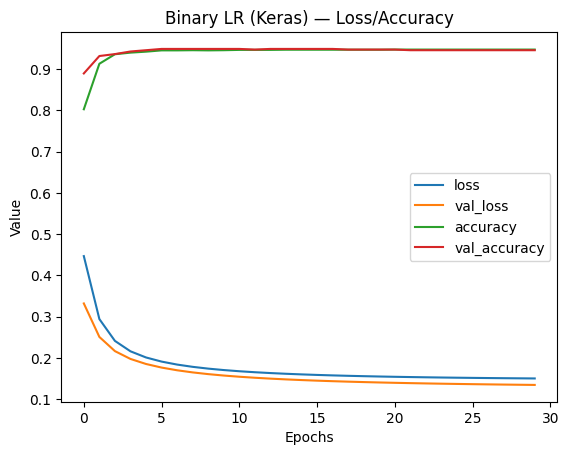

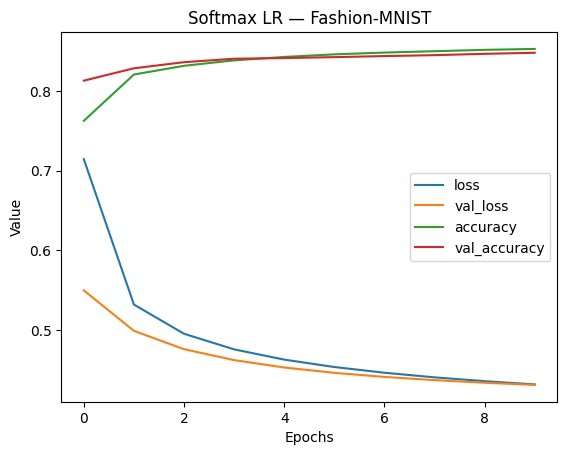

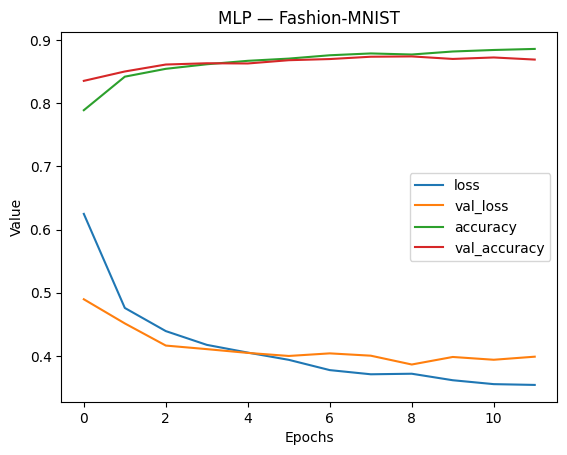

In [12]:
def plot_history(h, title="Training"):
    plt.figure()
    if 'loss' in h.history:
        plt.plot(h.history['loss'], label='loss')
    if 'val_loss' in h.history:
        plt.plot(h.history['val_loss'], label='val_loss')
    if 'accuracy' in h.history:
        plt.plot(h.history['accuracy'], label='accuracy')
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title(title)
    plt.xlabel("Epochs"); plt.ylabel("Value")
    plt.show()

plot_history(history, "Binary LR (Keras) — Loss/Accuracy")
plot_history(hist_softmax, "Softmax LR — Fashion-MNIST")
plot_history(hist_mlp, "MLP — Fashion-MNIST")

## 9) Confusion matrix for Fashion-MNIST models

In [14]:
def cm_and_report(model, X, y, title="Confusion Matrix"):
    y_pred = np.argmax(model.predict(X, verbose=0), axis=1)
    print(title)
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))

cm_and_report(softmax_model, x_te, y_te, title="[Softmax LR] Confusion Matrix & Report")
cm_and_report(mlp, x_te, y_te, title="[MLP] Confusion Matrix & Report")

[Softmax LR] Confusion Matrix & Report
[[859   4  13  45   6   1  61   0  11   0]
 [  6 953   2  30   5   0   2   0   2   0]
 [ 31   5 700  11 165   1  78   0   9   0]
 [ 42  11  12 875  25   0  31   0   4   0]
 [  0   3  82  51 780   1  76   0   7   0]
 [  0   0   0   2   0 903   0  58   4  33]
 [196   2 119  43 116   1 495   0  28   0]
 [  0   0   0   0   0  36   0 928   0  36]
 [  4   1   5  10   3   5  21   6 945   0]
 [  0   0   0   0   0  13   1  47   2 937]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.75      0.70      0.72      1000
           3       0.82      0.88      0.85      1000
           4       0.71      0.78      0.74      1000
           5       0.94      0.90      0.92      1000
           6       0.65      0.49      0.56      1000
           7       0.89      0.93      0.91      1000
           8       0.93      0.94      0.94